# Social Computing/Social Gaming - Summer 2023
# Exercise Sheet 6 - Transformers and Explainable AI

After we have worked out the base and social model on the previous sheet, we will now take a look into a model with a different approach. This time we will utilize Transformer-based classifiers. Transformers revolutionized NLP field significantly after the paper ["Attention is all your need"](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) was out. Then, a big [HuggingFace](https://huggingface.co/) platform [2] was created to store and host a lot of opensource NLP pre-trained models. We will work today with some of them.

Furthermore we will make use of SHAP and its underlying Shapley values to understand the basics of neural network explainability. This [site](https://christophm.github.io/interpretable-ml-book/shapley.html) [4] will help you to get an understanding of this concept.

In [1]:
import pandas as pd
import numpy as np

## Task 6.0: The Data

Once again we will use the dataset of Waseem and Hovy [1] as you are already familiar with it and it offers us the possibility to compare it to our previous work.

In [2]:
# Reads the data set from a .csv file
data_path="C:/Users/blody/Desktop/TUM/SC/ex_6/material/"
waseem_hovy = pd.read_csv(data_path+'tweets.csv')
waseem_hovy = waseem_hovy.astype(str)

# This drop operation is necessary because of an inconsistency in the dataset
waseem_hovy = waseem_hovy.drop([3343, 3344])
waseem_hovy = waseem_hovy[['text', 'label']]

# We need to do a unique and precise reordering to match with graph information later on
unique_tweets, indices = np.unique(waseem_hovy['text'].to_numpy(), return_index=True)
ordered_labels = waseem_hovy['label'].to_numpy()[indices]
waseem_hovy = pd.DataFrame(np.stack((unique_tweets, ordered_labels), axis=1), columns=['text', 'label'])
waseem_hovy.head(10)

C:\Users\blody\AppData\Local\Temp\ipykernel_43248\1214165970.py:3: DtypeWarning: Columns (2,30) have mixed types. Specify dtype option on import or set low_memory=False.
  waseem_hovy = pd.read_csv(data_path+'tweets.csv')


,text,label
0,"""@Brittany_Blade: #FemFreeFriday because fems ...",sexism
1,"""@CarlyandTresne: I still can't believe that K...",none
2,"""@CarlyandTresne: You don't suck Sheri and Emi...",none
3,"""@ColinCowell: Don't go bacon my heart ..........",none
4,"""@ErikssonMalin85: #QuestionsForMen ever walke...",sexism
5,"""@ErikssonMalin85: Have u ever expressed ur an...",sexism
6,"""@ErikssonMalin85: Have you ever been threaten...",sexism
7,"""@ErikssonMalin85: Why is a man afraid to comm...",sexism
8,"""@GidgitVonLaRue: #MKR How the fuck do you fuc...",none
9,"""@HebaDeee: Wait, where are Will and Steve? I'...",none


## Task 6.1: Preprocessing

### Encode the labels
Since we are using the same dataset, we need to covert their textual representation into numerical. For this task (almost the same as for a previous sheet), we can use [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
# Extract labels from dataset

original_labels = np.array(waseem_hovy["label"].tolist())

# TODO:
le = LabelEncoder()
le.fit(np.unique(original_labels))
data_labels = le.transform(original_labels)

# Shows the actual shape of the labels
print(original_labels.shape)
print(np.unique(original_labels))
print(np.unique(data_labels))
print(data_labels)
print(original_labels)

(16849,)
['none' 'racism' 'sexism']
[0 1 2]
[2 0 0 ... 0 0 0]
['sexism' 'none' 'none' ... 'none' 'none' 'none']


In the case of transforfer usage, we do not need to preprocess and tokenize sentences by ourselves -- that will be done by model's tokenizer! So, let us dive into transfermers right now!

## BERT for Toxic speech classification

We will fine-tune to our downstream task BERT model [3], more specifically -- distilled version of it [DistilBERT](https://huggingface.co/distilbert-base-uncased).

But, firstly, we need to install [transformers](https://huggingface.co/learn/nlp-course/chapter2/1?fw=pt) library:

In [5]:
# example of transformers library installation

#!pip install transformers

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification

In [7]:
# TODO: initialize tokenizer and model for DistilBERT or
# for other model of your preferences -- you are very welcome to try out something different!

from transformers import DistilBertTokenizer, DistilBertModel, TFDistilBertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, pipeline

name = 'distilbert-base-uncased'


tokenizer = AutoTokenizer.from_pretrained(name)
#model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=3, )
#model = TFDistilBertForSequenceClassification.from_pretrained(name)

id2label = {0: "none", 1: "racism", 2: "sexism"}
label2id = {"none": 0, "racism": 1, "sexism":2}
model = AutoModelForSequenceClassification.from_pretrained(
    name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

### Training Batches Preparation

The same as in the previous tutorial, we will create our custom datasets and loaders to generate batches for training. However, we need to adapt it to transformers input:

1.   Each dataset item should return ``input_ids``, ``attention_mask``, and ``label``.
2.   All should be ``tensors``.
3.   In the end, you need to apply ``collate_fn`` -- that will pad all tensors in batches to the max_length (already implemented for you).



In [11]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [9]:
# this is a special function that pad sequences in the batch for data loader

def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(np.array(item['input_ids'])) for item in batch], batch_first=True)
    attention_mask = torch.nn.utils.rnn.pad_sequence([torch.tensor(np.array(item['attention_mask'])) for item in batch], batch_first=True)
    labels = torch.tensor(np.array([item['label'] for item in batch]))

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels
    }

In [10]:
# TODO: create your CustomDataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {}
        item['input_ids'] = self.tokenizer(self.texts[index])["input_ids"]
        item['attention_mask'] = self.tokenizer(self.texts[index])["attention_mask"]
        item['label'] = self.labels[index]
        return item
# ––––––––––––––– End of Solution –––––––––––––––––––

In [11]:
from sklearn.model_selection import train_test_split

# TODO: Split tweets and labels in Train/Test/Validation 60/20/20

###

#splitting for training and testing
X_train, X_test, y_train, y_test = train_test_split(unique_tweets, data_labels, test_size=0.2, random_state=1)
#splitting for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


print("Training data shape: {}, Labels shape: {}".format(X_train.shape, y_train.shape))
print("Test data shape: {}, Labels shape: {}".format(X_test.shape, y_test.shape))
print("Validation data shape: {}, Labels shape: {}".format(X_val.shape, y_val.shape))

Training data shape: (10109,), Labels shape: (10109,)
Test data shape: (3370,), Labels shape: (3370,)
Validation data shape: (3370,), Labels shape: (3370,)


In [22]:
BATCH_SIZE = 128

# Create the Datasets
train_dataset = CustomDataset(X_train, y_train, tokenizer)
val_dataset = CustomDataset(X_val, y_val, tokenizer)
test_dataset = CustomDataset(X_test, y_test, tokenizer)

# DataLoader for batching and parallel data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

cnt = 0
for inputs in train_loader:
    if cnt<20:
        print(inputs)
        cnt +=1
    else: pass

{'input_ids': tensor([[  101, 19387,  1030,  ...,     0,     0,     0],
        [  101,  1030,  5199,  ...,     0,     0,     0],
        [  101,  6972,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  1030,  9152,  ...,     0,     0,     0],
        [  101,  2307, 12845,  ...,     0,     0,     0],
        [  101,  1030,  2012,  ...,     0,     0,     0]], dtype=torch.int32), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32), 'label': tensor([0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)}
{'input_ids': tensor([[  101, 19387,  1030,  ...,     0,     0,     0],
        [  101,  1000,  2027,  ...,     0,     0,     0],
        [  101,  1030, 19817,  ...,     0,     0,     0],
        ...,
     

{'input_ids': tensor([[  101,  2053,  2028,  ...,     0,     0,     0],
        [  101, 19387,  1030,  ...,     0,     0,     0],
        [  101, 19387,  1030,  ...,     0,     0,     0],
        ...,
        [  101, 19387,  1030,  ...,  2522,  1529,   102],
        [  101,  1001, 12395,  ...,     0,     0,     0],
        [  101,  1030, 17207,  ...,     0,     0,     0]], dtype=torch.int32), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32), 'label': tensor([2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 1, 0,
        0, 1, 0, 2, 0, 0, 0, 0], dtype=torch.int32)}
{'input_ids': tensor([[  101,  1000,  2069,  ...,     0,     0,     0],
        [  101,  2825, 14590,  ...,     0,     0,     0],
        [  101,  1001, 12395,  ...,     0,     0,     0],
        ...,
     

### Training Loop

We are ready to train the model! You can reuse the code from the previous tutorial:
1. Define ``optimizer`` and ``criterion`` for a classiication task.
2. Use ``train_loader`` to sample batches for training.
3. Track validation loss using data from ``val_loader``.
4. Achtung: now the items in batches have different structure!

In [13]:
import torch.nn as nn
from tensorflow.keras import activations, optimizers, losses

In [23]:
# TODO: define optimizer and criterion

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#model.train();

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [75]:
%%time

# TODO: implement training loop

# you can play with different number of epochs and check the model's performance!
num_epochs = 2

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    train_loss = 0
    train_steps = 0

    val_loss = 0
    val_acc = 0
    val_steps = 0
    
    
#     text = "I just had a really nice dinner"
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
#     outputs = model.forward(**inputs)
    model.train()
    for item in train_loader:
       
        inputs = item['input_ids']
        attention_mask = item['attention_mask']
        labels = item['label']
        labels = labels.type(torch.LongTensor)
        optimizer.zero_grad()
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        outputs['logits'] = outputs['logits'].type(torch.FloatTensor)
        #outputs.requires_grad=True
        loss = criterion(outputs['logits'], labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_steps += 1
        print("train")

    model.eval()
    with torch.no_grad():
     for item in val_loader:  
        inputs = item['input_ids']
        attention_mask = item['attention_mask']
        labels = item['label']
        labels = labels.type(torch.LongTensor)
        
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        outputs['logits'] = outputs['logits'].type(torch.FloatTensor)
        loss = criterion(outputs['logits'], labels)
        val_loss += loss.item()
        _, val_labels = torch.max(outputs['logits'], dim=1)
        val_acc += (val_labels == labels).sum().item() / labels.size(0)

        val_steps += 1
        print("val")
        
    train_loss_history.append(train_loss/train_steps)
    val_loss_history.append(val_loss/val_steps)
    val_accuracy_history.append(val_acc/val_steps)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss={train_loss/train_steps}, validation loss={val_loss/val_steps}, validation accuracy={val_acc/val_steps}')

###

train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
trai

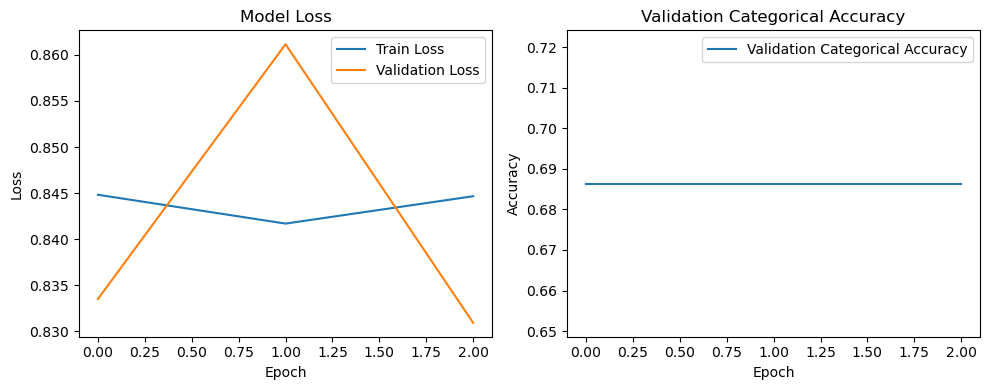

In [76]:
# TODO: Evaluate the model based on test_loader
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation categorical accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation Categorical Accuracy')
plt.title('Validation Categorical Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## SHAP Explanations

Now, we have a decent model for toxic speech detection. However, sometimes it can be not so clear why some sample is considered toxic or not. We can try to explaine the model's decision! For this, we utilize [SHAP](https://shap.readthedocs.io/en/latest/index.html).

In [15]:
# example of module installation

# !pip install shap

In [16]:
import sys
sys.path.append('C:/Users/blody/Desktop/TUM/SC/ex_6/material/src')
sys.path.append('C:/Users/blody/Desktop/TUM/SC/ex_6/material/src/evaluation.py')

In [17]:
import matplotlib.pyplot as plt
import shap
from explainability import shap_explain_text

# Initializes JavaScript to visualize plots generated by Shap
shap.initjs()

# in order to try using a gpu to speed up the computations i ended up uninstalling pytorch and all that came with it 
# so the output of this cell should be ignored (the output of all of the other cells is saved from previous attempts)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\blody\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
  File "C:\Users\blody\AppData\Local\Temp\ipykernel_43248\2777464565.py", line 1, in <module>
    import matplotlib.pyplot as plt
ModuleNotFoundError: No module named 'matplotlib'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\blody\anaconda3\lib\site-packages\pygments\styles\__init__.py", line 78, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\blody\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2057, in showtraceback
  File "C:\Users\blody\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1118, in structured_traceback
  File "C:\Users\blody\anaconda3\lib\site-packages\IPython\core\ul

### Let's inspect our model!

#### Easy initialization and exploration of a cherry-picked sample.

In [80]:
import transformers

In [81]:
# We need to create a text-classification pipeline to input it to the explainer

pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, return_all_scores=True)

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [82]:
# This is the example how to define Explainer from SHAP

explainer = shap.Explainer(pred)
text = ['only men can have higher education']
shap_values = explainer(text)

In [83]:
shap.plots.text(shap_values)


In addition to slicing, Explanation objects also support a set of reducing methods. Here we use the ``.mean(0)`` to take the average impact of all words towards the “sexism” (``idx=2``) class. Note that here we are also averaging over three examples, to get a better summary you would want to use a larger portion of the dataset.

In [88]:
shap.plots.text(shap_values[:, :, 1])

In [100]:
pred("Only men can have higher education")


[[{'label': 'none', 'score': 0.6654641628265381},
  {'label': 'racism', 'score': 0.12626560032367706},
  {'label': 'sexism', 'score': 0.20827019214630127}]]

In [101]:
pred("I like ice cream")
# the scores are entirely similar except with a Tiny difference in 'racism' rating? 

[[{'label': 'none', 'score': 0.6654641628265381},
  {'label': 'racism', 'score': 0.12626561522483826},
  {'label': 'sexism', 'score': 0.20827019214630127}]]

### We can also work with already fine-tuned for sexism classification models.

There are already different models fine-tuned for toxic or sexism speech detection. You can load, for instance, our model [bertweet-sexism](https://huggingface.co/tum-nlp/bertweet-sexism) and try to explaine it as well!

In [89]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [90]:
# TODO: define tokenizer and model for bertweet-sexism instance.

# Load model and tokenizer
tokenizer_auto = AutoTokenizer.from_pretrained('tum-nlp/bertweet-sexism')
model_auto = AutoModelForSequenceClassification.from_pretrained('tum-nlp/bertweet-sexism')

# Create the pipeline for classification
sexism_classifier = pipeline("text-classification", model=model_auto, tokenizer=tokenizer_auto)

Here a small example on cherry-picked sentence to explaine the model:

In [92]:
# TODO: inspect the model on the sample!
#sexism_classifier("I like ice cream")

e = sexism_classifier("I don't like to call women bitches or sluts, I think it's bad.")
print(e)
###

[{'label': 'LABEL_1', 'score': 0.9995965361595154}]


In [93]:
explainer_s = shap.Explainer(sexism_classifier)
text_s = ['only men can have higher education']
shap_values_s = explainer_s(text_s)
shap.plots.text(shap_values_s[:, :, 1])

  0%|          | 0/56 [00:00<?, ?it/s]

Partition explainer: 2it [00:11, 11.51s/it]                                                                            


**TODO: how can we understand if some model is better or not?**
You can pick the misclassified samples for each model and compare the explanations. Can you explaine why the model did mistakes? Are these mistakes the same or not? Try out other ways how to use SHAP [here](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html). Maybe, other ways of explanations can be useful more?

**TODO: Write your observations here**

The second (sexism only) model made a mistake with regards to the second input ('I don't like to call women...'), labelling it as sexist, even though the sentiment, despite the presence of overtly sexist vocabulary, was not sexist by itself. 

The first model was either trained incorrectly (my mistake with understanding the assignment) or was not given enough epochs to train (two out of five times I ran the train/val the graph looked like some of the 'earlier' epochs tend to look on graphs with ~20 epochs). Another possible reason is too high of a learning rate.

**Concluding questions:**
* Do the hate scores perform as expected in our model?
* If not, can you come up with a possible explanation for that even though the models with social scores performed better?
* What does that tell you about applicability of neural networks and their trustworthiness?

**TODO: Write your answers here**

The hate scores performed mostly as expected, at least in the second model (I'm gonna consider it for these answers, seeing as there is something clearly wrong with mine.)
I would say that the mistakes it made point to the limited (at least for now) usage capabilities with regards to nuance. After all, some people would claim that even the usage of sexist terms, no matter the context, is sexist by itself (same applies to any other demeaning vocabulary). 

### <center> Thank you for participating in Social Computing/Social Gaming 2023. </center>
### <center> Good luck with the exams! </center>

## References

[1] Waseem, Z., & Hovy, D. (2016). Hateful symbols or hateful people? Predictive features for hate speech detection on Twitter. In Proceedings of the naacl student research workshop (pp. 88-93).
<br> [2] [HuggingFace Tutorial](https://huggingface.co/learn/nlp-course/chapter1/1)
<br> [3] [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
<br> [4] https://christophm.github.io/interpretable-ml-book/shapley.html